# Lab Session: Building a Transformer Language Model

In this session, you will build and train a simple Transformer-based language model from scratch. Key parts of the implementation are masked so you can fill in the details.

**Important:** *Feel free to rewrite a function that include `#[YOUR CODE HERE]` from scratch if you prefer. This will help deepen your understanding by implementing the logic independently rather than just filling in the blanks.*


## Tasks

1. **Data Preparation:**  
   - Load the TinyStories dataset using Hugging Face's `datasets` library.
   - Create a custom `TextDataset` class to split texts into fixed-length sequences.

2. **BPE Tokenization:**  
   - Implement a simple Byte Pair Encoding (BPE) tokenizer.
   - Build vocabulary mappings and implement `encode`/`decode` functions.

3. **Transformer Model:**  
   - Implement core components: sinusoidal positional embeddings, multi-head attention, feedforward network, and layer normalization.
   - Assemble these into a complete Transformer architecture (some parts are masked for you to complete).

4. **Training and Evaluation:**  
   - Train your model and monitor the training loss in real time.
   - Evaluate model performance using perplexity.
   - Implement text generation using nucleus (top‑p) sampling.

In [ ]:
#@title Setup

!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
import random
from tqdm import trange, tqdm
import math

# Hugging Face datasets
from datasets import load_dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [ ]:
#@title Load Dataset

dataset_name = "roneneldan/TinyStories"  # official HhggingFace name

# if you don't want to store the entire dataset locally, use: load_dataset(dataset_name, split="train", streaming=True)
train_data = load_dataset(dataset_name, split="train", download_mode="reuse_dataset_if_exists")
dev_data   = load_dataset(dataset_name, split="validation", download_mode="reuse_dataset_if_exists")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

# Implement a Simple BPE Tokenizer

Here we implement a very basic version of byte-pair encoding. For each word we start with characters (with an end-of-word marker), then we iteratively merge the most frequent pair. Finally, we collect all tokens into a vocabulary and print some statistics.

In [ ]:
#@title BPE Tokenizer Implementation

class BPETokenizer:
    def __init__(self, vocab_size):
        # Initialize the BPETokenizer with a target vocabulary size.
        # Note: The actual number of tokens may be slightly less than vocab_size,
        #       because the merging process might terminate early.
        self.vocab_size = vocab_size
        self.token2id = {}  # Mapping from token (string) to unique integer ID.
        self.id2token = {}  # Reverse mapping from ID to token.
        self.bpe_merges = []  # List to store the sequence of merge operations learned.

    def get_stats(self, corpus):
        """
        Count the frequency of each adjacent symbol pair in the corpus.

        Parameters:
            corpus (dict): A dictionary where keys are strings representing words
                           (tokens separated by spaces) and values are their frequency counts.

        Returns:
            pairs (dict): A dictionary where keys are tuples of adjacent symbols (pairs)
                          and values are the total frequency of that pair in the corpus.
        """
        pairs = {}
        # Iterate over every word (represented as a string of space-separated tokens) in the corpus.
        for word, freq in corpus.items():
            # Split the word into its individual symbols (tokens).
            symbols = word.split()
            # Loop over each adjacent pair in the symbol sequence.
            for i in range(len(symbols) - 1):
                pair = (symbols[i], symbols[i+1])
                # Add the frequency of the word to the pair's count.
                pairs[pair] = pairs.get(pair, 0) + freq
        return pairs

    def merge_vocab(self, pair, corpus):
        """
        Merge the specified pair (most frequent pair) in every word in the corpus.

        Parameters:
            pair (tuple): The pair of symbols to merge (e.g., ('a', 'b')).
            corpus (dict): The current corpus dictionary with words as keys and frequency as values.

        Returns:
            new_corpus (dict): A new corpus dictionary where every occurrence of the pair is merged.
        """
        new_corpus = {}
        # Create a string representing the pair as it appears in the word (e.g., "a b").
        bigram = ' '.join(pair)
        # The merged token will be the two symbols concatenated (e.g., "ab").
        replacement = ''.join(pair)
        # For each word in the corpus, replace the bigram with the merged token.
        for word, freq in corpus.items():
            # Replace all occurrences of the bigram with the replacement token.

            #[YOUR CODE HERE]
        return new_corpus

    def learn_bpe(self, texts):
        """
        Learn the Byte Pair Encoding (BPE) merges from a list of texts.

        The process involves:
          1. Tokenizing each word into characters (with an end-of-word marker).
          2. Iteratively finding the most frequent pair of tokens and merging them.
          3. Stopping when the desired number of merges (approximate vocabulary size) is reached.

        Parameters:
            texts (iterable): An iterable of strings, each representing a text sample.

        Returns:
            token2id (dict): Mapping from each token (string) to its unique integer ID.
            id2token (dict): Reverse mapping from integer IDs to tokens.
        """
        # Build an initial corpus: each word is represented as a sequence of characters
        # with an end-of-word marker ('</w>') to distinguish similar sequences.
        corpus = {}
        for text in texts:
            # Split the text into words.
            words = text.strip().split()
            for word in words:
                # Split the word into characters and add an end-of-word marker.
                tokenized = ' '.join(list(word)) + ' </w>'
                # Update the frequency of this tokenized word in the corpus.
                corpus[tokenized] = corpus.get(tokenized, 0) + 1

        # Iteratively perform merges until we have performed vocab_size number of merges.
        # Using trange provides a progress bar for the merge iterations.
        for i in trange(self.vocab_size, desc="BPE Merges", unit="merge"):
            # Get frequency statistics for all adjacent symbol pairs.
            pairs = self.get_stats(corpus)
            # If there are no more pairs to merge, exit the loop early.
            if not pairs:
                print("No more pairs to merge at iteration", i)
                break
            # Find the most frequent pair in the corpus.
            best_pair = max(pairs, key=pairs.get)
            # Merge the best pair in the corpus.
            corpus = self.merge_vocab(best_pair, corpus)
            # Record this merge operation.
            self.bpe_merges.append(best_pair)

        # After learning the merges, build the final vocabulary.
        tokens = set()
        # For each word in the corpus, add its tokens (split by space) to the vocabulary set.
        for word in corpus.keys():
            tokens.update(word.split())
        # Create a mapping from tokens to unique IDs (sorting for consistency).
        self.token2id = {token: idx for idx, token in enumerate(sorted(tokens))}
        # Create the reverse mapping.
        self.id2token = {idx: token for token, idx in self.token2id.items()}
        return self.token2id, self.id2token

    def encode(self, text):
        """
        Encode a given text string into a sequence of token IDs based on the learned BPE merges.

        The encoding process is:
          1. Split each word into characters (plus the end-of-word marker).
          2. Iteratively apply the learned merge operations to combine characters into tokens.
          3. Convert the resulting tokens into their corresponding IDs.

        Parameters:
            text (str): The text string to be encoded.

        Returns:
            tokens_ids (list): A list of integer token IDs representing the input text.
        """
        tokens_ids = []
        # Process each word in the text separately.
        for word in text.strip().split():
            # Start with the word as a list of characters and add the end-of-word marker.
            token = list(word) + ['</w>']
            # Apply each learned merge in the order they were learned.
            for merge in self.bpe_merges:
                new_token = []
                i = 0
                # Go through the token list and merge where applicable.
                while i < len(token):
                    # Check if the current token and the next token form the merge pair.
                    if i < len(token) - 1 and (token[i], token[i+1]) == merge:
                        # Merge the pair and add the merged token to new_token.
                        new_token.append(token[i] + token[i+1])
                        i += 2  # Skip the next token as it's merged.
                    else:
                        # If no merge, simply add the current token to new_token.
                        new_token.append(token[i])
                        i += 1
                # Update token list with the result of current merge pass.
                token = new_token
            # Convert each token into its corresponding ID.
            # If a token isn't found in token2id, it defaults to 0 (unknown token).
            token_ids = [self.token2id.get(t, 0) for t in token]
            # Extend the overall list of token IDs with those from the current word.
            tokens_ids.extend(token_ids)
        return tokens_ids

    def decode(self, token_ids):
        """
        Decode a sequence of token IDs back into a text string.

        The decoding process is:
          1. Convert each token ID to its corresponding token string using the id2token mapping.
          2. Concatenate all token strings into one continuous string.
          3. Replace the end-of-word marker '</w>' with a space to reconstruct word boundaries.
          4. Strip any extra whitespace from the beginning and end of the string.

        Parameters:
            token_ids (list): A list of integer token IDs.

        Returns:
            text (str): The decoded text string.
        """
        # Convert each token ID to the corresponding token string.
        tokens = [self.id2token.get(i, '') for i in token_ids]

        # Join all tokens into a single string.
        # Since tokens were originally generated without spaces between them,
        # we simply join them with an empty separator.
        text = ''.join(tokens)

        # Replace the end-of-word marker '</w>' with a space.
        # This reconstructs the word boundaries.
        text = text.replace('</w>', ' ')

        # Strip leading and trailing whitespace and return the decoded text.
        return text.strip()

In [ ]:
#@title Building the Vocabulary

all_train_texts = train_data['text']

# Define the subset size (number of samples to use for BPE training)
subset_size = 20000  # Adjust this value as needed.

# If the dataset is larger than the subset size, sample randomly.
if len(all_train_texts) > subset_size:
    train_texts_subset = random.sample(all_train_texts, subset_size)
else:
    train_texts_subset = all_train_texts

# Define the target vocabulary size (number of merge operations)
vocab_target_size = 500  # Adjust as needed.
tokenizer = BPETokenizer(vocab_size=vocab_target_size)
token2id, id2token = tokenizer.learn_bpe(train_texts_subset)


BPE Merges: 100%|██████████| 500/500 [00:40<00:00, 12.46merge/s]


In [ ]:
print("Vocabulary size learned:", len(token2id))
print("Sample tokens:", list(token2id.items())[200:300])

Vocabulary size learned: 6366
Sample tokens: [('Mim', 200), ('Min', 201), ('Mind</w>', 202), ('Mine', 203), ('Mine,</w>', 204), ('Mine</w>', 205), ('Mineral</w>', 206), ('Mira', 207), ('Mira.</w>', 208), ('Mira</w>', 209), ('Mirac', 210), ('Miranda.</w>', 211), ('Miranda</w>', 212), ('Miss</w>', 213), ('Mista', 214), ('Mister', 215), ('Mit', 216), ('Mitten', 217), ('Mitten</w>', 218), ('Mom', 219), ('Mom.</w>', 220), ('Mom</w>', 221), ('Moments</w>', 222), ('Momo', 223), ('Momo,</w>', 224), ('Momo</w>', 225), ('N', 226), ('O', 227), ('On', 228), ('On</w>', 229), ('Once</w>', 230), ('One', 231), ('One,</w>', 232), ('One.</w>', 233), ('One</w>', 234), ('Oni', 235), ('P', 236), ('Q', 237), ('R', 238), ('S', 239), ('Sam</w>', 240), ('Sara</w>', 241), ('She</w>', 242), ('Su', 243), ('Suc', 244), ('Such</w>', 245), ('Sudden', 246), ('Suddenly,</w>', 247), ('Suddent', 248), ('Sum', 249), ('Sun', 250), ('Sun.</w>', 251), ('Sun</w>', 252), ('Sunita', 253), ('Sunita</w>', 254), ('Super', 255), (

# Transformer Implementation

We now implement the components of our Transformer and put them together in one class.

## Positional Encoding

In [ ]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=512):
        """
        Initializes the SinusoidalPositionalEmbedding module.

        Parameters:
        - d_model (int): The dimensionality of the model embeddings.
                         This is the size of each positional embedding vector.
        - max_len (int): The maximum sequence length for which to generate positional embeddings.

        The sinusoidal positional embeddings are defined using sine and cosine functions
        of different frequencies. They allow the model to learn about the relative positions
        of tokens in a sequence without adding any trainable parameters for the positions.

        The mathematical formulation is as follows:

            PE(pos, 2i)   = sin(pos / (10000^(2i/d_model)))
            PE(pos, 2i+1) = cos(pos / (10000^(2i/d_model)))

        where pos is the position (0-indexed) and i is the dimension index.
        """
        super(SinusoidalPositionalEmbedding, self).__init__()

        # Create a tensor of shape (max_len, 1) representing positions from 0 to max_len-1.
        # This will be used to calculate the sine and cosine values.
        position = #[YOUR CODE HERE]

        # Compute the scaling factor for each dimension.
        # torch.arange(0, d_model, 2) creates a tensor for even indices: [0, 2, 4, ..., d_model-2] (if d_model is even).
        # The formula below calculates the exponent term: -(log(10000) / d_model) * index.
        div_term = #[YOUR CODE HERE]

        # Initialize a positional encoding matrix of shape (max_len, d_model) with zeros.
        pe = #[YOUR CODE HERE]

        # For even dimensions (indices 0, 2, 4, ...), use the sine function.
        # Here, position * div_term performs element-wise multiplication, broadcasting div_term over positions.
        pe[:, 0::2] = torch.sin(position * div_term)

        # For odd dimensions (indices 1, 3, 5, ...), use the cosine function.
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension so that the positional encoding tensor has shape (1, max_len, d_model).
        # This facilitates adding the positional encoding directly to the input embeddings.
        pe = pe.unsqueeze(0)

        # Register the positional encoding as a buffer. This ensures it is part of the module's state,
        # but it is not updated during training (i.e., not a trainable parameter).
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Provides the sinusoidal positional embeddings corresponding to the input tensor.

        Parameters:
        - x (Tensor): The input tensor with shape (batch_size, seq_len, d_model).

        Returns:
        - Tensor: A tensor containing the positional embeddings of shape (1, seq_len, d_model).
                  This can be directly added to the token embeddings.
        """
        # x.size(1) retrieves the sequence length (T) of the input.
        # We return only the first T positions of the precomputed positional encoding.
        return #[YOUR CODE HERE]


## LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        """
        Initialize the LayerNorm module.

        Parameters:
        - hidden_size (int): The number of features (i.e., the size of the last dimension of the input).
        - eps (float): A small constant added to the standard deviation for numerical stability.
        """
        super(LayerNorm, self).__init__()
        # Create a learnable scale parameter (gamma) for each feature,
        # initialized to 1, which will be used to scale the normalized output.
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        # Create a learnable bias parameter (beta) for each feature,
        # initialized to 0, which will be used to shift the normalized output.
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        # Save the epsilon value for use in the normalization process.
        self.eps = eps

    def forward(self, x):
        """
        Apply layer normalization to the input tensor x.

        Layer normalization normalizes the input across the last dimension (features)
        for each data point independently. This is useful in stabilizing and accelerating
        training in deep networks.

        Parameters:
        - x (Tensor): Input tensor with shape (..., hidden_size).

        Returns:
        - Tensor: The normalized tensor, scaled by gamma and shifted by beta.
        """
        # Compute the mean of x over the last dimension (features), while keeping the dimensions for broadcasting.
        mean = #[YOUR CODE HERE]
        # Compute the standard deviation of x over the last dimension (features), keeping dimensions for broadcasting.
        std = #[YOUR CODE HERE]
        # Normalize the tensor: subtract the mean and divide by the standard deviation plus a small epsilon.
        # Then, apply the learnable scaling (gamma) and shifting (beta) parameters.
        normalized = #[YOUR CODE HERE]
        return self.gamma * normalized + self.beta


## Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        """
        Initialize the multi-head attention module.

        Parameters:
        - hidden_size (int): Dimensionality of the input embeddings (and output).
        - num_heads (int): Number of attention heads. Must divide hidden_size evenly.
        - dropout (float): Dropout probability applied to the attention weights.
        """
        super(Attention, self).__init__()

        # Ensure the hidden size can be evenly split among the attention heads.
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"

        self.num_heads = num_heads
        # Calculate the dimension of each head (i.e., each head will operate on a portion of the hidden size).
        self.head_dim = hidden_size // num_heads

        # Define linear transformations for queries, keys, and values.
        # Each transformation maps the input from hidden_size to hidden_size.
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)

        # Define a linear layer for the final output after concatenating all heads.
        self.out = nn.Linear(hidden_size, hidden_size)

        # Define dropout to apply to the attention weights for regularization.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Perform a forward pass of multi-head attention.

        Parameters:
        - x (Tensor): Input tensor of shape (B, T, C), where:
                      B = batch size,
                      T = sequence length,
                      C = hidden_size.
        - mask (Tensor, optional): A mask to prevent attention to certain positions (e.g., padding or future tokens).
                                   Should be broadcastable to shape (B, num_heads, T, T).

        Returns:
        - out (Tensor): Output tensor of shape (B, T, C) after applying attention.
        """
        B, T, C = x.size()  # Batch size, sequence length, and embedding dimension.

        # ================== Linear Projections ==================
        # Apply linear layers to generate query, key, and value representations.
        # These projections transform the input x into three separate spaces.
        q = #[YOUR CODE HERE]  # Shape: (B, T, C)
        k = #[YOUR CODE HERE]    # Shape: (B, T, C)
        v = #[YOUR CODE HERE]  # Shape: (B, T, C)

        # ================== Reshape for Multi-Head Attention ==================
        # We need to split the embedding dimension into multiple heads.
        # Reshape and transpose the tensor so that each head can operate in parallel.
        # New shape after view: (B, T, num_heads, head_dim)
        # After transpose: (B, num_heads, T, head_dim)
        q = #[YOUR CODE HERE]
        k = #[YOUR CODE HERE]
        v = #[YOUR CODE HERE]

        # ================== Scaled Dot-Product Attention ==================
        # Compute raw attention scores by performing matrix multiplication between queries and keys.
        # k.transpose(-2, -1) swaps the last two dimensions of k for proper dot product calculation.
        # The division by sqrt(head_dim) helps to scale the scores and maintain stable gradients.
        scores = #[YOUR CODE HERE]  # Shape: (B, num_heads, T, T)

        # If a mask is provided, apply it here:
        # - The mask should have values of 0 (to mask out) and 1 (to keep).
        # - masked_fill replaces positions with 0 in the mask with -inf, so that after softmax these positions receive 0 attention.
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to obtain attention weights.
        # Softmax is applied along the last dimension (over T) so that the weights sum to 1 for each query.
        attn = #[YOUR CODE HERE]

        # Optionally apply dropout to the attention weights for regularization.
        attn = #[YOUR CODE HERE]

        # Compute the context (weighted sum of values) using the attention weights.
        # Matrix multiplication of attention weights (attn) and values (v) results in a tensor of shape (B, num_heads, T, head_dim)
        context = #[YOUR CODE HERE]

        # ================== Concatenate Heads and Project ==================
        # Transpose the context back to shape (B, T, num_heads, head_dim)
        # Then reshape (flatten) the last two dimensions to combine all heads into one tensor of shape (B, T, C).
        context = #[YOUR CODE HERE]

        # Finally, pass the concatenated context through a linear layer to mix the information from different heads.
        out = #[YOUR CODE HERE]

        # Return the final output tensor.
        return out


## FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_size, dropout=0.1):
        """
        Initializes the FeedForward module which implements a simple two-layer
        fully connected network with a ReLU activation and dropout between the layers.

        Parameters:
        - hidden_size (int): The input (and output) dimensionality.
        - ff_size (int): The inner dimensionality (size of the hidden layer).
        - dropout (float): Dropout probability applied after the activation.
        """
        super(FeedForward, self).__init__()
        # First linear layer transforms the input from hidden_size to ff_size.
        self.fc1 = nn.Linear(hidden_size, ff_size)
        # Second linear layer transforms the hidden representation back to hidden_size.
        self.fc2 = nn.Linear(ff_size, hidden_size)
        # Dropout layer to help regularize the model and prevent overfitting.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the feedforward network.

        Steps:
        1. Apply the first linear transformation.
        2. Apply the ReLU activation function to introduce non-linearity.
        3. Apply dropout for regularization.
        4. Apply the second linear transformation to return to the original hidden size.

        Parameters:
        - x (Tensor): Input tensor of shape (B, T, hidden_size), where:
                      B = batch size, T = sequence length.

        Returns:
        - Tensor: Output tensor of the same shape as the input.
        """
        # Linear transformation from hidden_size to ff_size.
        x = #[YOUR CODE HERE]
        # Apply ReLU activation for non-linearity.
        x = #[YOUR CODE HERE]
        # Apply dropout to the activated values.
        x = #[YOUR CODE HERE]
        # Linear transformation from ff_size back to hidden_size.
        x = #[YOUR CODE HERE]
        return x


## TransformerLayer

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size, dropout=0.1):
        """
        Initializes a single transformer layer, which consists of:
          1. A multi-head attention sub-layer.
          2. A feedforward sub-layer.
          3. Residual (skip) connections and layer normalization applied after each sub-layer.

        Parameters:
        - hidden_size (int): Dimensionality of the input embeddings.
        - num_heads (int): Number of attention heads for the multi-head attention mechanism.
        - ff_size (int): Dimensionality of the feedforward network's inner layer.
        - dropout (float): Dropout probability used in both sub-layers.
        """
        super(TransformerLayer, self).__init__()
        # Multi-head attention module (assumed to be defined elsewhere).
        self.attention = Attention(hidden_size, num_heads, dropout)
        # Layer normalization after the attention sub-layer.
        self.ln1 = LayerNorm(hidden_size)
        # Feedforward network sub-layer.
        self.ff = FeedForward(hidden_size, ff_size, dropout)
        # Layer normalization after the feedforward sub-layer.
        self.ln2 = LayerNorm(hidden_size)
        # Dropout to be applied to the outputs of both sub-layers before adding the skip connection.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Forward pass of the transformer layer.

        Process:
        1. Compute the attention output using multi-head attention.
        2. Apply dropout to the attention output and add a skip connection to the original input.
        3. Normalize the result with layer normalization.
        4. Pass the normalized output through the feedforward network.
        5. Again, apply dropout and add a skip connection.
        6. Final layer normalization of the output.

        Parameters:
        - x (Tensor): Input tensor of shape (B, T, hidden_size).
        - mask (Tensor, optional): Attention mask to prevent attention to certain positions (e.g., padding tokens).

        Returns:
        - Tensor: Output tensor of shape (B, T, hidden_size) after processing through the transformer layer.
        """
        # ===== Attention Sub-layer =====
        # Compute attention outputs using multi-head attention.
        attn_out = #[YOUR CODE HERE]
        # Add dropout and add the original input to form the residual (skip) connection.
        x = #[YOUR CODE HERE]
        # Apply layer normalization to the sum.
        x = #[YOUR CODE HERE]

        # ===== FeedForward Sub-layer =====
        # Process the output from the attention block through the feedforward network.
        ff_out = #[YOUR CODE HERE]
        # Add dropout and the original input (post-attention) for the residual connection.
        x = #[YOUR CODE HERE]
        # Final layer normalization after the feedforward sub-layer.
        x = #[YOUR CODE HERE]

        return x


## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_heads, ff_size, max_len=512, dropout=0.1):
        """
        Initializes a transformer model for language modeling using sinusoidal positional encodings.
        The model consists of:
          1. Token embeddings.
          2. Fixed sinusoidal positional encodings.
          3. A stack of transformer layers.
          4. A final linear projection to map the hidden state to vocabulary logits.

        Parameters:
        - vocab_size (int): The number of tokens in the vocabulary.
        - hidden_size (int): Dimensionality of the token embeddings and transformer hidden states.
        - num_layers (int): Number of transformer layers (blocks) to stack.
        - num_heads (int): Number of attention heads in each transformer layer.
        - ff_size (int): Dimensionality of the feedforward sub-layer inside each transformer block.
        - max_len (int): Maximum sequence length for positional encodings.
        - dropout (float): Dropout probability for regularization.
        """
        super(Transformer, self).__init__()
        self.hidden_size = hidden_size

        # ===== Embedding Layers =====
        # Token embedding: Maps each token index to a hidden_size-dimensional vector.
        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        # Sinusoidal positional encoding: A fixed (non-trainable) encoding that adds positional information.
        self.sinusoidal_pos_embedding = SinusoidalPositionalEmbedding(d_model=hidden_size, max_len=max_len)

        # ===== Transformer Layers =====
        # Create a stack of transformer layers using a ModuleList.
        # Each TransformerLayer applies multi-head attention and a feedforward network.
        self.layers = nn.ModuleList(
            [TransformerLayer(hidden_size, num_heads, ff_size, dropout) for _ in range(num_layers)]
        )

        # ===== Final Processing Layers =====
        # Final layer normalization applied after processing through all transformer layers.
        self.ln = LayerNorm(hidden_size)
        # Final linear layer that projects the hidden state to vocabulary logits.
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        # Dropout applied to the combined embeddings before feeding into the transformer layers.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Forward pass of the transformer model using sinusoidal positional encodings.

        Process:
        1. Compute token embeddings.
        2. Obtain the fixed sinusoidal positional encodings.
        3. Add the token embeddings and positional encodings.
        4. Apply dropout to the combined embeddings.
        5. Pass the embeddings through each transformer layer in the stack.
        6. Apply final layer normalization.
        7. Project the output to vocabulary logits using a linear layer.

        Parameters:
        - x (Tensor): Input tensor of token indices with shape (B, T), where:
                      B = batch size, T = sequence length.
        - mask (Tensor, optional): An attention mask for the transformer layers (should be broadcastable to shape (B, num_heads, T, T)).

        Returns:
        - logits (Tensor): Output logits of shape (B, T, vocab_size) for predicting the next token.
        """
        B, T = x.size()  # Batch size and sequence length.

        # Look up token embeddings from the token embedding layer.
        token_embeds = #[YOUR CODE HERE]  # Shape: (B, T, hidden_size)

        # Get the sinusoidal positional encodings.
        # The SinusoidalPositionalEmbedding module returns a tensor of shape (1, T, hidden_size).
        pos_embeds = #[YOUR CODE HERE]

        # Combine token embeddings with positional encodings.
        # The positional information is added element-wise.
        x = #[YOUR CODE HERE]

        # Apply dropout to the combined embeddings for regularization.
        x = #[YOUR CODE HERE]

        # Pass the embeddings through each transformer layer in the stack.
        for layer in self.layers:
            #[YOUR CODE HERE]

        # Apply final layer normalization.
        x = #[YOUR CODE HERE]

        # Project the normalized output to obtain logits for each token in the vocabulary.
        logits = #[YOUR CODE HERE]
        return logits


# Prepare Data for Training

We define a simple Dataset class that uses our BPE tokenizer to convert text into token IDs and forms blocks (sequences) for language modeling.

In [ ]:
#@title Creating a Dataset Class

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, block_size=50):
        """
        Initializes the TextDataset and creates overlapping training blocks from the input texts.

        The dataset is created by:
          1. Converting each text string into a sequence of token IDs using the tokenizer.
          2. Creating overlapping blocks (subsequences) from each tokenized text.
             Each block has a length of block_size + 1 tokens.
             The extra token at the end serves as the target for the previous tokens.

        A progress bar is displayed while processing the texts to show how many texts have been handled.

        Parameters:
        - texts (iterable): A list (or other iterable) of text strings. Each string is a piece of text from your dataset.
        - tokenizer: A tokenizer object with an 'encode' method that converts a text string into a list of token IDs.
        - block_size (int): The fixed length of each block (sequence) used for training.
        """
        self.tokenizer = tokenizer  # Save the tokenizer for use during encoding.
        self.block_size = block_size  # Save the block size.
        self.data = []  # This list will store all the training blocks.

        # Use tqdm to show a progress bar while processing each text.
        for text in tqdm(texts, desc="Creating dataset", unit="text"):
            # Convert the text string to a list of token IDs.
            token_ids = self.tokenizer.encode(text)

            # Create overlapping blocks for training.
            # For example, if token_ids has 100 tokens and block_size is 50,
            # then the loop will create blocks like:
            # [token_ids[0:51]], [token_ids[1:52]], [token_ids[2:53]], and so on.
            for i in range(0, len(token_ids) - block_size):
                # Each block is block_size+1 tokens long. The extra token serves as the target for the previous tokens.
                self.data.append(token_ids[i:i+block_size+1])

    def __len__(self):
        """
        Returns the total number of training blocks (examples) in the dataset.
        This value is used by PyTorch to know how many samples are available.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single training example from the dataset.

        The block (a list of token IDs) at the given index is split into two parts:
          - Input: All tokens except the last token.
          - Target: All tokens except the first token (i.e., shifted one position to the right).

        Both parts are converted into PyTorch tensors of type torch.long.

        Parameters:
        - idx (int): The index of the desired training example.

        Returns:
        - input_ids (Tensor): The tensor of input tokens with shape (block_size,).
        - target_ids (Tensor): The tensor of target tokens with shape (block_size,).
        """
        block = self.data[idx]
        # The input is the sequence of tokens from the start up to (but not including) the last token.
        input_ids = torch.tensor(block[:-1], dtype=torch.long)
        # The target is the sequence of tokens from the second token to the end.
        target_ids = torch.tensor(block[1:], dtype=torch.long)
        return input_ids, target_ids


In [ ]:
#@title Loading the dataset and dataloader for Training

all_train_texts = train_data['text']

# Define the subset size
subset_size = 1000  # Adjust this value as needed.

# If the dataset is larger than the subset size, sample randomly.
if len(all_train_texts) > subset_size:
    train_texts_subset = random.sample(all_train_texts, subset_size)
else:
    train_texts_subset = all_train_texts

# Define the block size (number of tokens in each sequence used for training)
block_size = 50

# Create an instance of TextDataset.
# 'train_texts_subset' is assumed to be a list of text strings (e.g., the one we loaded from the TinyStories dataset),
# and 'tokenizer' is an object that implements an encode() method (e.g. the BPE tokenizer we implemented earlier).
train_dataset = TextDataset(train_texts_subset, tokenizer, block_size=block_size)

# Define the batch size (number of training examples per batch).
batch_size = 32

# Create a DataLoader, which is a PyTorch utility that handles batching and shuffling.
# Setting shuffle=True means the dataset is randomly shuffled at the start of each epoch.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Now, 'train_dataloader' can be used in a training loop to iterate over batches of input and target tokens.


# Training the Transformer Model

In [ ]:
#@title Hyperparameters and Model Setup

# Vocabulary size: number of unique tokens in the dataset.
vocab_size = len(token2id)

# hidden_size: Dimensionality of the token embeddings and transformer hidden states.
hidden_size = 128

# num_layers: Number of transformer layers to stack.
num_layers = 2

# num_heads: Number of attention heads in each multi-head attention module.
num_heads = 4

# ff_size: Size of the feedforward network (inner layer) within each transformer layer.
ff_size = 256

# dropout: Dropout probability for regularization (helps prevent overfitting).
dropout = 0.1

# num_epochs: Total number of times the model will see the entire dataset during training.
num_epochs = 3

# learning_rate: Step size used by the optimizer for updating model parameters.
learning_rate = 1e-3


In [ ]:
#@title Initialize the Transformer Model

# Create an instance of the Transformer model.
model = Transformer(vocab_size, hidden_size, num_layers, num_heads, ff_size,
                    max_len=block_size, dropout=dropout)

# Determine the device (GPU if available, else CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device (GPU or CPU).

# -------------------------------
# Optimizer and Loss Function
# -------------------------------
# Using Adam optimizer to update the model parameters.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# The loss function is CrossEntropyLoss, which is common for classification tasks.
# In language modeling, each token prediction is treated as a classification problem.
criterion = nn.CrossEntropyLoss()


Epoch 1/3: 100%|██████████| 9806/9806 [01:49<00:00, 89.51it/s]


Epoch 1/3, Loss: 0.0671


Epoch 2/3: 100%|██████████| 9806/9806 [01:51<00:00, 87.94it/s]


Epoch 2/3, Loss: 0.0657


Epoch 3/3: 100%|██████████| 9806/9806 [01:45<00:00, 93.14it/s] 


Epoch 3/3, Loss: 0.0645


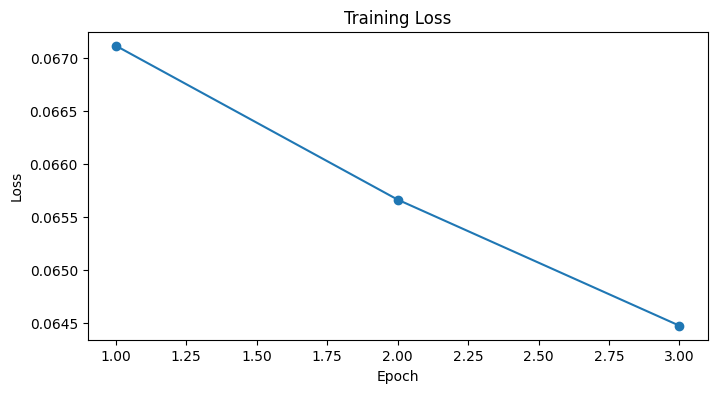

In [ ]:
#@title Training the Transformer

train_losses = []  # List to store the average loss for each epoch.

# Loop over the number of epochs.
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (activates dropout, etc.)
    epoch_loss = 0  # Variable to accumulate loss over the epoch.

    # Wrap the dataloader with tqdm to display a progress bar for batches.
    # The 'desc' argument provides a description for the progress bar.
    # 'leave=True' makes sure the progress bar is kept after the loop completes.
    for inputs, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
        # Move the batch data to the selected device (GPU or CPU).
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Clear gradients from the previous iteration.

        # Forward pass: Compute the model output (logits) for the given inputs.
        logits = model(inputs)

        # Reshape logits and targets for the loss function:
        # - logits.view(-1, vocab_size): Flattens the logits to a 2D tensor of shape (N, vocab_size),
        #   where N is the total number of token predictions in the batch.
        # - targets.view(-1): Flattens the target tensor to a 1D tensor of shape (N).
        loss = #[YOUR CODE HERE]

        loss.backward()  # Backward pass: Compute the gradients of the loss with respect to model parameters.
        optimizer.step()  # Update the model parameters using the optimizer.

        # Add the loss for this batch to the epoch's cumulative loss.
        epoch_loss += loss.item()

    # Compute the average loss for this epoch.
    avg_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Print out the epoch number and average loss.
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# -------------------------------
# Visualize Training Progress
# -------------------------------
# Create a plot to visualize the training loss over epochs.
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
#@title Saving the Model
torch.save(model.state_dict(), "transformer_model.pth")
print("Model weights saved.")

Model weights saved.


# Evaluation and Text Generation

In [ ]:
#@title Creating the Dataset for Evaluation

all_dev_texts = dev_data['text']

# Define the subset size
dev_subset_size = 1000  # Adjust this value as needed.

# If the dataset is larger than the subset size, sample randomly.
if len(all_dev_texts) > dev_subset_size:
    dev_texts_subset = random.sample(all_dev_texts, dev_subset_size)
else:
    dev_texts_subset = all_dev_texts

# Define the block size (number of tokens in each sequence used for evaluation)
block_size = 50

# Create an instance of TextDataset.
dev_dataset = TextDataset(dev_texts_subset, tokenizer, block_size=block_size)

# Define the batch size (number of training examples per batch).
batch_size = 32

# Create a DataLoader, which is a PyTorch utility that handles batching and shuffling.
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

Creating dataset: 100%|██████████| 1000/1000 [00:40<00:00, 24.92text/s]


In [ ]:
#@title Perplexity

# Set the model to evaluation mode. This disables dropout and other training-specific behaviors.
model.eval()

total_loss = 0      # This will accumulate the total loss over all evaluation batches.
total_tokens = 0    # This will count the total number of tokens processed.

# Disable gradient computation during evaluation for speed and memory efficiency.
with torch.no_grad():
    # Wrap the dev_dataloader with tqdm to display a progress bar.
    for inputs, targets in tqdm(dev_dataloader, desc="Evaluating", leave=True):
        # Move the input and target tensors to the same device as the model (GPU or CPU).
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass: Compute the model's predictions (logits) for the given inputs.
        logits = #[YOUR CODE HERE]

        # Reshape logits and targets to prepare them for the loss function.
        # - logits.view(-1, vocab_size): Flattens the logits to a 2D tensor of shape (N, vocab_size),
        #   where N is the total number of token predictions in the batch.
        # - targets.view(-1): Flattens the target tensor to a 1D tensor of shape (N).
        loss = #[YOUR CODE HERE]

        # Since the loss is averaged over all tokens in the batch,
        # multiply by the number of tokens in the batch to get the total loss for the batch.
        batch_tokens = targets.numel()  # .numel() returns the total number of elements (tokens) in the batch.
        total_loss += loss.item() * batch_tokens

        # Accumulate the total number of tokens processed.
        total_tokens += batch_tokens

# Compute the average loss per token across the entire development set.
avg_loss = total_loss / total_tokens

# Perplexity is defined as the exponential of the average cross-entropy loss.
perplexity = #[YOUR CODE HERE]

print("Perplexity:", perplexity)


Evaluating: 100%|██████████| 9418/9418 [00:38<00:00, 241.56it/s]

Perplexity: 1.0630292851827543


In [ ]:
#@title Text Generation with a Prompt

import torch.nn.functional as F

def generate_text(model, tokenizer, prompt, max_length=100, top_p=0.9, temperature=1.0, device='cpu'):
    """
    Generate text using nucleus (top-p) sampling.

    Parameters:
    - model (nn.Module): The trained transformer model.
    - tokenizer: An object with 'encode' and 'decode' methods.
      * tokenizer.encode(text) converts text to a list of token IDs.
      * tokenizer.decode(list_of_ids) converts a list of token IDs back to text.
    - prompt (str): The initial text prompt to start generation.
    - max_length (int): The maximum number of tokens to generate.
    - top_p (float): The cumulative probability threshold for nucleus sampling.
      Only the smallest set of tokens whose total probability exceeds this value will be considered.
    - temperature (float): Value used to control randomness in sampling. (1.0 means no change)
    - device (str): The device to run the model on (e.g., 'cpu' or 'cuda').

    Returns:
    - generated_text (str): The text generated by the model.
    """
    # Set the model to evaluation mode to disable dropout and other training-specific behavior.
    model.eval()

    # Encode the prompt into token IDs.
    # Assume tokenizer.encode returns a list of integers.
    input_ids = tokenizer.encode(prompt)

    # Convert the list of token IDs into a PyTorch tensor and add a batch dimension.
    # The resulting tensor has shape (1, sequence_length).
    generated = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)

    # Disable gradient computations for inference.
    with torch.no_grad():
        # Generate up to max_length new tokens.
        for _ in range(max_length):
            # Get model outputs for the current sequence.
            # Expected shape: (batch_size, sequence_length, vocab_size)
            outputs = #[YOUR CODE HERE]

            # Focus on the logits for the last token in the sequence.
            # This yields a tensor of shape (batch_size, vocab_size).
            next_token_logits = outputs[:, -1, :]

            # Apply temperature scaling to control randomness.
            next_token_logits = next_token_logits / temperature

            # Convert logits to probabilities.
            probs = #[YOUR CODE HERE]

            # ----- Nucleus (top-p) Sampling Implementation -----
            # 1. Sort the probabilities in descending order.
            sorted_probs, sorted_indices = #[YOUR CODE HERE]

            # 2. Compute the cumulative probabilities of the sorted tokens.
            cumulative_probs = #[YOUR CODE HERE]

            # 3. Create a mask for tokens whose cumulative probability exceeds top_p.
            sorted_indices_to_remove = #[YOUR CODE HERE]

            # 4. Shift the mask to the right so that at least one token is always kept.
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            # 5. Set probabilities for tokens outside the nucleus to 0.
            sorted_probs[sorted_indices_to_remove] = 0.0

            # 6. Renormalize the remaining probabilities so they sum to 1.
            sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

            # 7. Sample one token from the nucleus distribution.
            #    torch.multinomial returns the index within sorted_probs.
            next_token_index = #[YOUR CODE HERE]

            # 8. Map the sampled index back to the actual token ID using sorted_indices.
            #    next_token will have shape (batch_size, 1).
            next_token = sorted_indices.gather(dim=-1, index=next_token_index)

            # Append the sampled token to the generated sequence.
            # Since 'generated' has shape (batch_size, current_sequence_length) and
            # 'next_token' has shape (batch_size, 1), they can be concatenated along dim=1.
            generated = torch.cat((generated, next_token), dim=1)

            # Optional: Stop generation if an end-of-sequence token is generated.
            # if next_token.item() == tokenizer.eos_token_id:
            #     break

    # Remove the batch dimension and convert the tensor of token IDs to a Python list.
    generated_ids = generated.squeeze(0).tolist()

    # Decode the token IDs back into text.
    generated_text = tokenizer.decode(generated_ids)

    return generated_text


In [ ]:
# Example usage:
prompt = "Once upon a time"
generated_output = generate_text(model, tokenizer, prompt, max_length=45, top_p=0.9, temperature=1.0, device=device)
print(generated_output)


Once upon a time daring. daring. daring. daring. daring. daring. daring. we. we. we. we. we. we. we. we. we. we. we. we. daring. we. daring. Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her Her
